Check the available GPU.

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')
print(device_lib.list_local_devices())

2025-01-23 11:23:56.715607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 11:23:56.746261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 11:23:56.755622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 11:23:56.779290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-23 11:23:57.930080: W tensorflow/compiler/tf2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17544871572550815979
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 626720768
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4741713839791492484
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:03:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-01-23 11:23:58.839851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 597 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:03:00.0, compute capability: 7.5


Show the patches of one image.

Set the folders conatining the input images and the masks

In [2]:
input_folder = '/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/input/'
masks_folder = '/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/masks/'

<_MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None)>
(1, 27, 30, 196608)
27 30


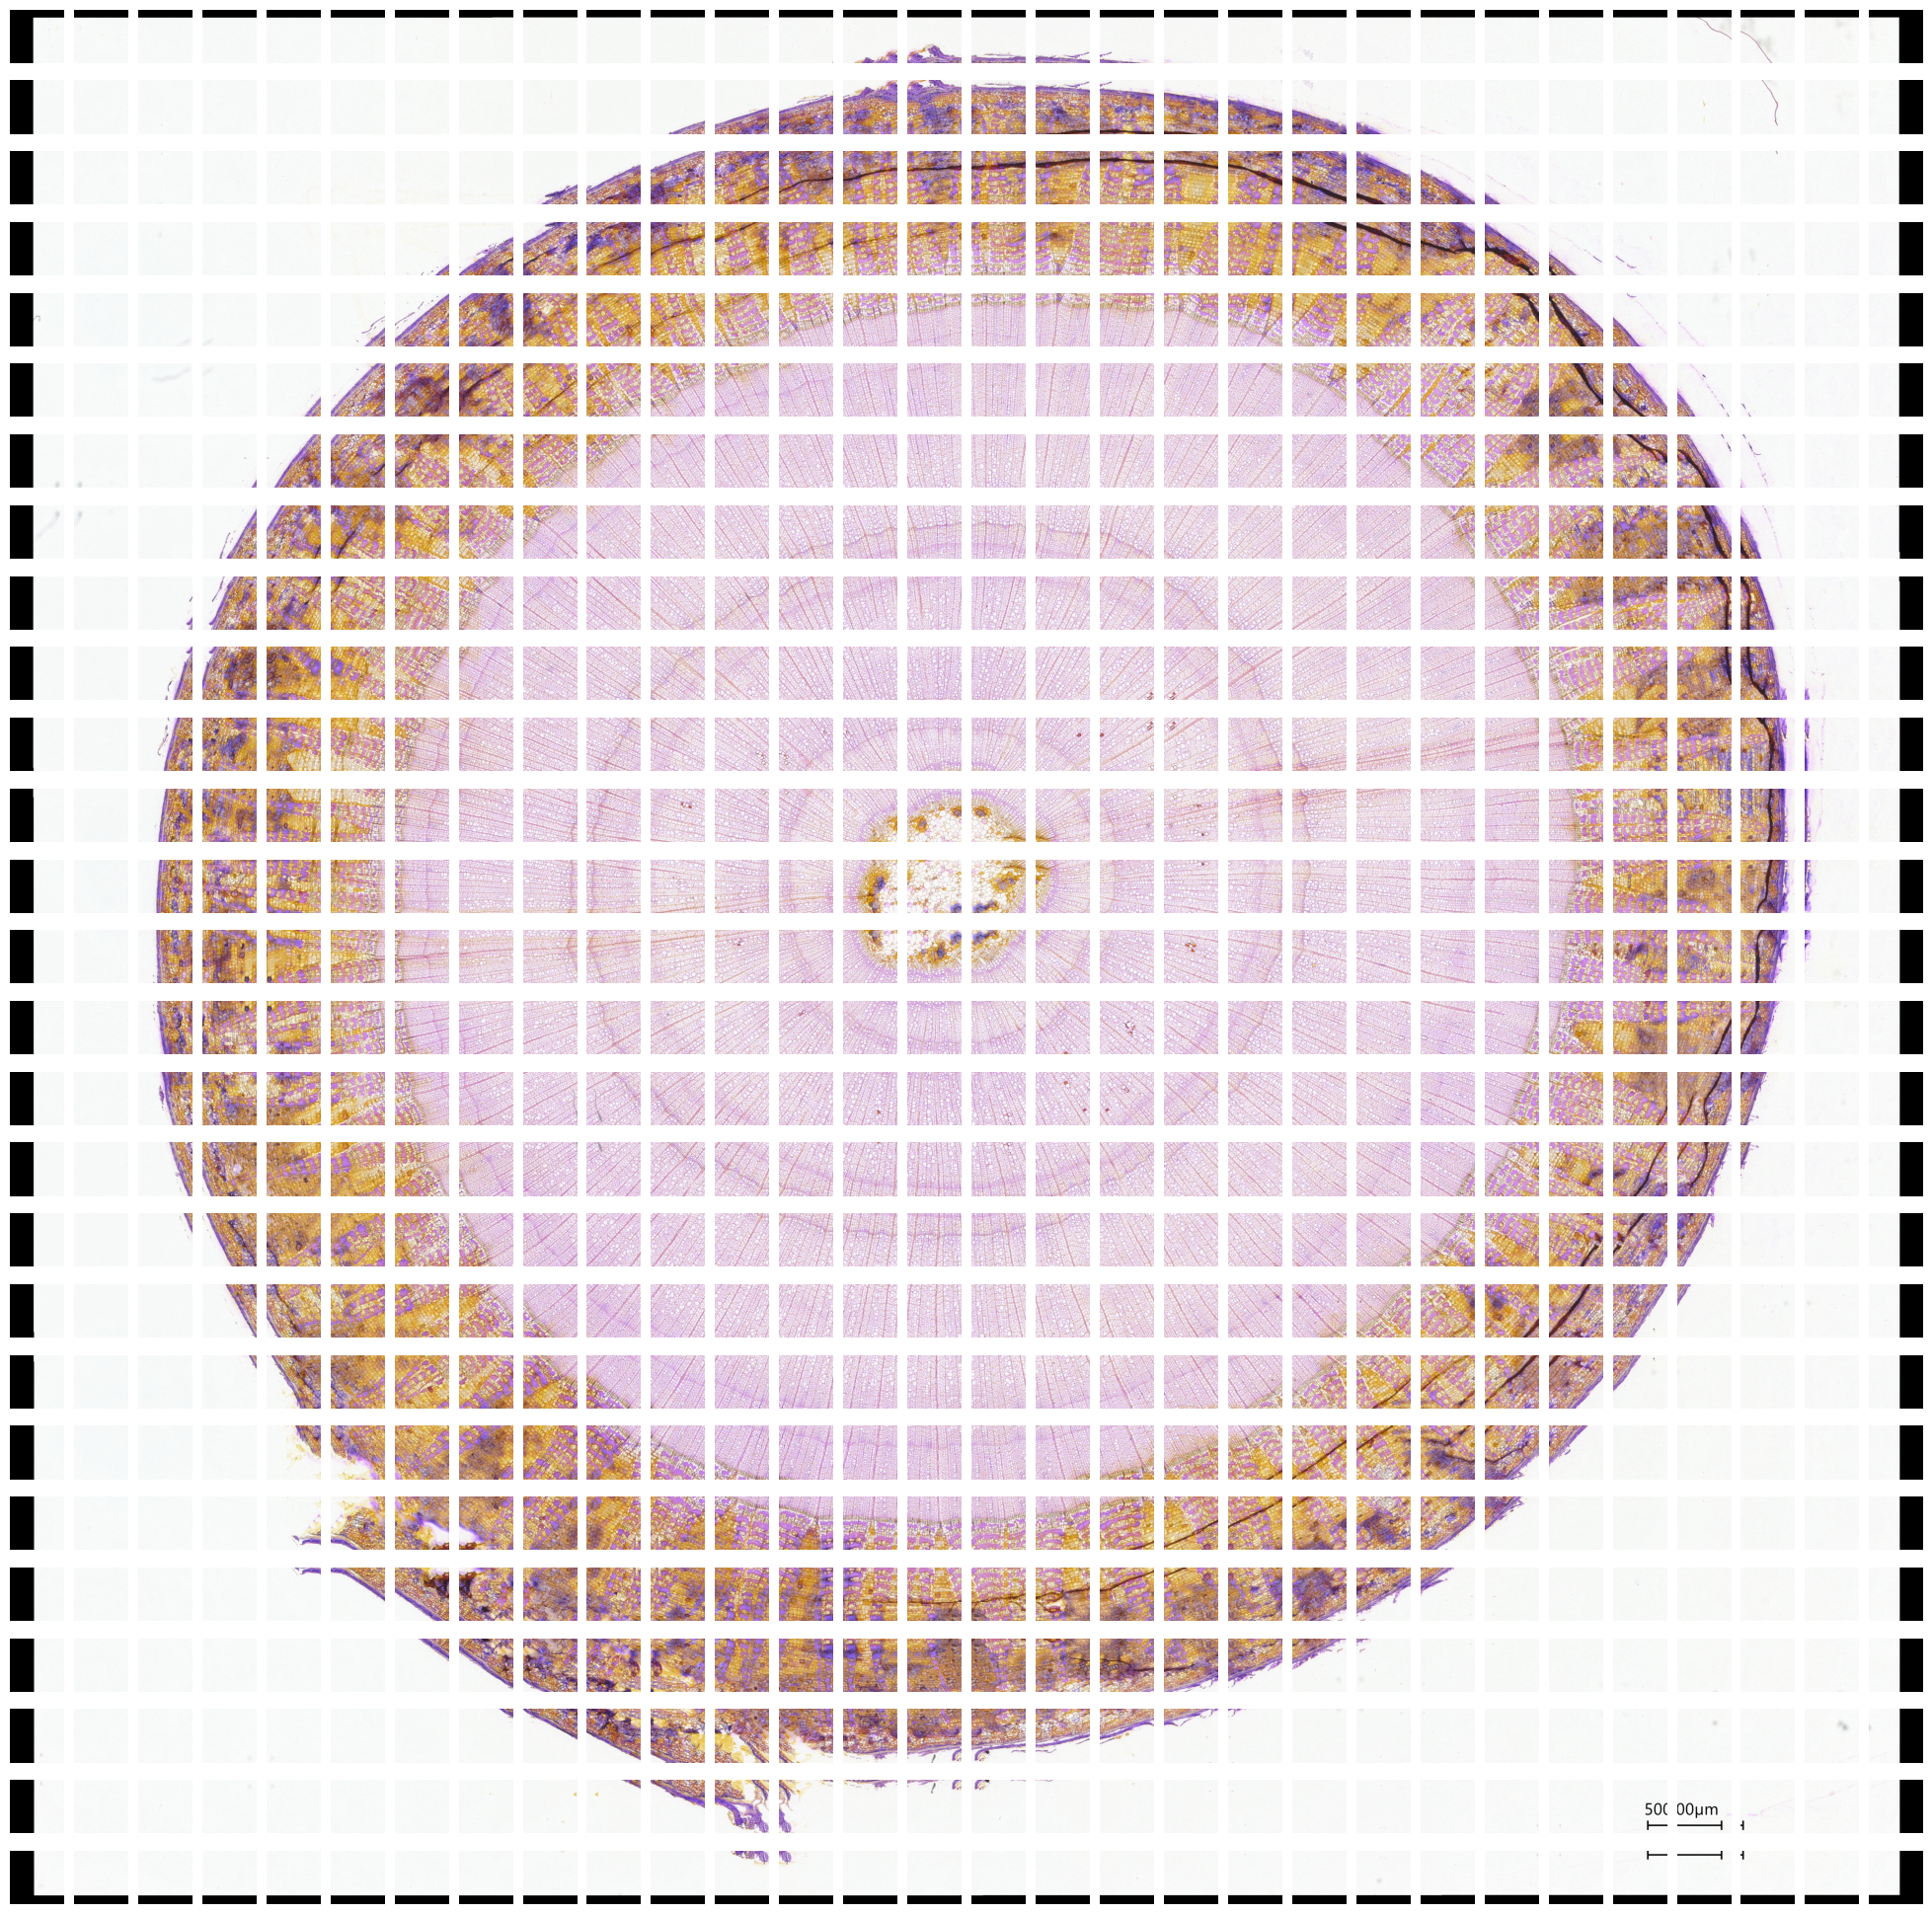

In [5]:
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import cv2

image_file = '/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/T 5 t_8µm_x50.tif'

def parse_with_opencv(image_path):
    return cv2.imread(image_path.decode('UTF-8'))

img_path = [image_file]

ds = tf.data.Dataset.from_tensor_slices(img_path).map(
    lambda x: tf.numpy_function(parse_with_opencv, [x], Tout=tf.uint8)
) 



ksize_rows = 256
ksize_cols = 256
strides_rows = 196
strides_cols = 196


image = ds # tfio.experimental.image.decode_tiff(image_data)

print(image)
# The size of sliding window
ksizes = [1, ksize_rows, ksize_cols, 1] 

# How far the centers of 2 consecutive patches are in the image
strides = [1, strides_rows, strides_cols, 1]

# The document is unclear. However, an intuitive example posted on StackOverflow illustrate its behaviour clearly. 
# http://stackoverflow.com/questions/40731433/understanding-tf-extract-image-patches-for-extracting-patches-from-an-image
rates = [1, 1, 1, 1] # sample pixel consecutively

# padding algorithm to used
padding='SAME' # or 'SAME'

# image = tf.expand_dims(image, 0)
image_patches = tf.image.extract_patches(images=list(ds), sizes=ksizes, strides=strides, rates=rates, padding=padding)

# print image shape of image patches
print(image_patches.shape)

# image_patches is 4 dimension array, you can use tf.squeeze to squeeze it, e.g.
# image_patches = tf.squeeze(image_patches)
columns = image_patches.shape[1]
rows = image_patches.shape[2]

print(columns, rows)
# retrieve the 1st patches
fig = plt.figure(figsize=(25, 25)) 
fig.tight_layout()
i = 1
for col in range(columns):
    for row in range(rows):
        patch = image_patches[0,col,row,]
        patch = tf.reshape(patch, [ksize_rows, ksize_cols, 3])        
        fig.add_subplot(columns, rows, i) 
        plt.axis('off') 
        plt.imshow(patch)
        i = i + 1
# visualize image

plt.show()

Export all patches from all images in a folder and the patches of the corresponding masks and filter out patches and masks for which the mask is empty.

In [ ]:
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import cv2
import os

def main():
    exportPatches(input_folder)
    exportPatches(masks_folder)
    filterEmptyPatches(input_folder, masks_folder)

def parse_with_opencv(image_path):
    return cv2.imread(image_path.decode('UTF-8'))

def exportPatches(folder):
    out_folder = os.path.join(folder, "patches")
    os.makedirs(out_folder, exist_ok=True)
    files = os.listdir(folder)
    paths = [os.path.join(folder, file) for file in files if file.endswith(".tif") or file.endswith(".jpg")]
    ksize_rows = 256
    ksize_cols = 256
    strides_rows = 196
    strides_cols = 196
    # The size of sliding window
    ksizes = [1, ksize_rows, ksize_cols, 1] 
    # How far the centers of 2 consecutive patches are in the image
    strides = [1, strides_rows, strides_cols, 1]
    # The document is unclear. However, an intuitive example posted on StackOverflow illustrate its behaviour clearly. 
    # http://stackoverflow.com/questions/40731433/understanding-tf-extract-image-patches-for-extracting-patches-from-an-image
    rates = [1, 1, 1, 1] # sample pixel consecutively
    # padding algorithm to used
    padding='SAME' # or 'SAME'

    imageNumber = 1
    for img_path in paths:
        ds = tf.data.Dataset.from_tensor_slices([img_path]).map(
            lambda x: tf.numpy_function(parse_with_opencv, [x], Tout=tf.uint8)
        ) 
        image_patches = tf.image.extract_patches(images=list(ds), sizes=ksizes, strides=strides, rates=rates, padding=padding)
        columns = image_patches.shape[1]
        rows = image_patches.shape[2]    
        patchNumber = 1
        for col in range(columns):
            for row in range(rows):
                image_name, ext = os.path.splitext(img_path)
                image_name = os.path.basename(image_name)
                patch = image_patches[0,col,row,]
                patch = tf.reshape(patch, [ksize_rows, ksize_cols, 3])
                image_name = image_name + "_r" + str(row).zfill(4) + "_c" + str(col).zfill(4) + ext
                out_path = os.path.join(out_folder, image_name)
                print("\rsaving image nr.: " + str(imageNumber) + " of " + str(len(paths)) + ", patch nr.: " + str(patchNumber) + " of " + str(columns * rows) + "     ", end="")
                cv2.imwrite(out_path, patch.numpy())               
                patchNumber = patchNumber + 1
        imageNumber = imageNumber + 1


main()

Remove patches with empty masks

In [ ]:
def main():
    image_patches_folder = os.path.join(input_folder, "patches")
    mask_patches_folder = os.path.join(masks_folder, "patches")
    filterEmptyPatches(image_patches_folder, mask_patches_folder)  


def filterEmptyPatches(image_patches_folder, mask_patches_folder):
    masks = os.listdir(mask_patches_folder)
    mask_paths = [os.path.join(mask_patches_folder, file) for file in masks if file.endswith(".tif") or file.endswith(".jpg")]
    file_paths = [os.path.join(image_patches_folder, file) for file in masks if file.endswith(".tif") or file.endswith(".jpg")]
    fileNumber = 1
    for mask_path, file_path in zip(mask_paths, file_paths):
        print("\rProcessing file " + str(fileNumber) + " of " + str(len(mask_paths)) + "        ", end="")
        mask = cv2.imread(mask_path, 0)
        if cv2.countNonZero(mask) == 0:
            os.remove(mask_path)
            os.remove(file_path)
            print("\rDeleting...                                                       ", end="")
        fileNumber = fileNumber + 1

main()

Put 20% of the data aside as the test dataset.

In [ ]:
import random 
import numpy as np
import os

def main():
    image_patches_folder = os.path.join(input_folder, "patches")
    mask_patches_folder = os.path.join(masks_folder, "patches")
    masks = os.listdir(mask_patches_folder)
    mask_paths = [os.path.join(mask_patches_folder, file) for file in masks if file.endswith(".tif") or file.endswith(".jpg")]
    image_paths = [os.path.join(image_patches_folder, file) for file in masks if file.endswith(".tif") or file.endswith(".jpg")]
    maskOutFolder = os.path.join(masks_folder, "test_patches")
    imageOutFolder = os.path.join(input_folder, "test_patches")
    os.makedirs(maskOutFolder, exist_ok=True)
    os.makedirs(imageOutFolder, exist_ok=True)
    N = len(mask_paths)
    number = round((N * 20) / 100)
    indices = random.sample(range(N), number)
    selectedMaskPaths = np.array(mask_paths)[indices]
    selectedImagePaths = np.array(image_paths)[indices]
    counter = 1
    for maskPath, imagePath in zip(selectedMaskPaths, selectedImagePaths):
        print("\rProcessing image " + str(counter) + " of " + str(len(selectedMaskPaths)) + "        ", end="")
        maskName = os.path.basename(maskPath)
        imageName = os.path.basename(imagePath)
        os.rename(maskPath, os.path.join(maskOutFolder, maskName))
        os.rename(imagePath, os.path.join(imageOutFolder, imageName))
        counter = counter + 1

main()